In [1]:
import numpy as np

import matplotlib.pyplot as plt

def plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X, return_std=True)
    plt.fill_between(X.ravel(), 
                     mu.ravel() + 1.96 * std, 
                     mu.ravel() - 1.96 * std, 
                     alpha=0.1) 
    plt.plot(X, Y,  lw=1, label='Noise-free objective')
    plt.plot(X, mu, lw=1, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y,  lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()  

In [2]:
from scipy.stats import norm
import numpy as np
noise = 0.01
def made_v3(x1):
    loc1 = -2
    scale1 = 1.0
    
    loc2 = 3.5
    scale2 = 0.2
    
    def pdf_v1(x):
        return norm.pdf(x, loc=loc1, scale=scale1)*2
    
    def delta_func(x):
        return np.greater(x,3.9) * np.less(x,4.1) * (3)
    
    mu,var = 0.0, 1e-2
    return (pdf_v1(x1) + delta_func(x1)) +  noise * np.random.randn(*x1.shape)

In [3]:
%matplotlib inline

bounds = np.array([[-5.0, 5.0]])


f = made_v3

X_init = np.array([[-2.9], [0.5],[-2.5],[2.3]])
Y_init = f(X_init)

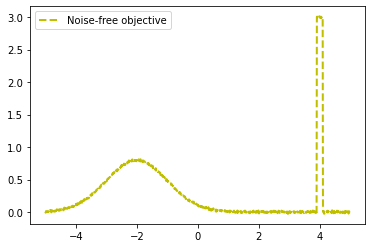

In [4]:
import matplotlib.pyplot as plt

# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
#plt.plot(X, f(X), 'bx', lw=1, alpha=0.1, label='Noisy samples')
#plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

In [5]:
from scipy.stats import norm

def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.1):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [...]
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei.ravel()

In [6]:
from scipy.optimize import minimize

def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=10000):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x    
    
            
    return min_x.reshape(-1, 1)

In [7]:
from scipy.optimize import minimize

def propose_location_with_acq_val(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    #for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
    xs = np.linspace(bounds[:,0], bounds[:,1],10000)
    best_acq_ind = np.argmin(min_obj(xs))
    x0 = xs[best_acq_ind]
    #for x0 in np.linspace(bounds[:,0], bounds[:,1], 10000):
    
        #res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        #if res.fun < min_val:
        #    min_val = res.fun[0]
        #    min_x = res.x           
        
    res = minimize(min_obj, x0=x0, bounds=bounds, method="L-BFGS-B")
    if(res.x < bounds[:,1] and res.x > bounds[:,0]):
        min_val = res.fun[0]
        min_x = res.x
    else:
        min_x = x0
        min_val = min_obj(x0)
    
            
    return min_x.reshape(-1, 1), min_val

-0.021892742130160334
[-0.00169942]
[-0.0002356]
-2.634361040665601e-05
-1.3357901470524543e-08
-5.2302243913788076e-11
-3.2324201740746754e-17
-2.462608958303353e-35
-2.5480260214098193e-39
-2.840865647480842e-44
-2.009878117419858e-55
-1.2451495225459993e-62
-1.7964038909439113e-77
-5.662401190077116e-92
-2.449513335043843e-97
-9.440094221620153e-104
-4.7805227189442645e-116
-7.21429965385678e-123
-3.1650644552024743e-133
-9.473949806100867e-157
-1.7276665115682934e-159
-2.2814066831012783e-180
-4.456387124312079e-181
-1.455967572166958e-189
-1.4835029596869022e-200
-1.9800382210273616e-204
-3.2610431822965912e-205
-3.6616414894335203e-227
-9.25610107405598e-229
-3.4705130310574746e-246


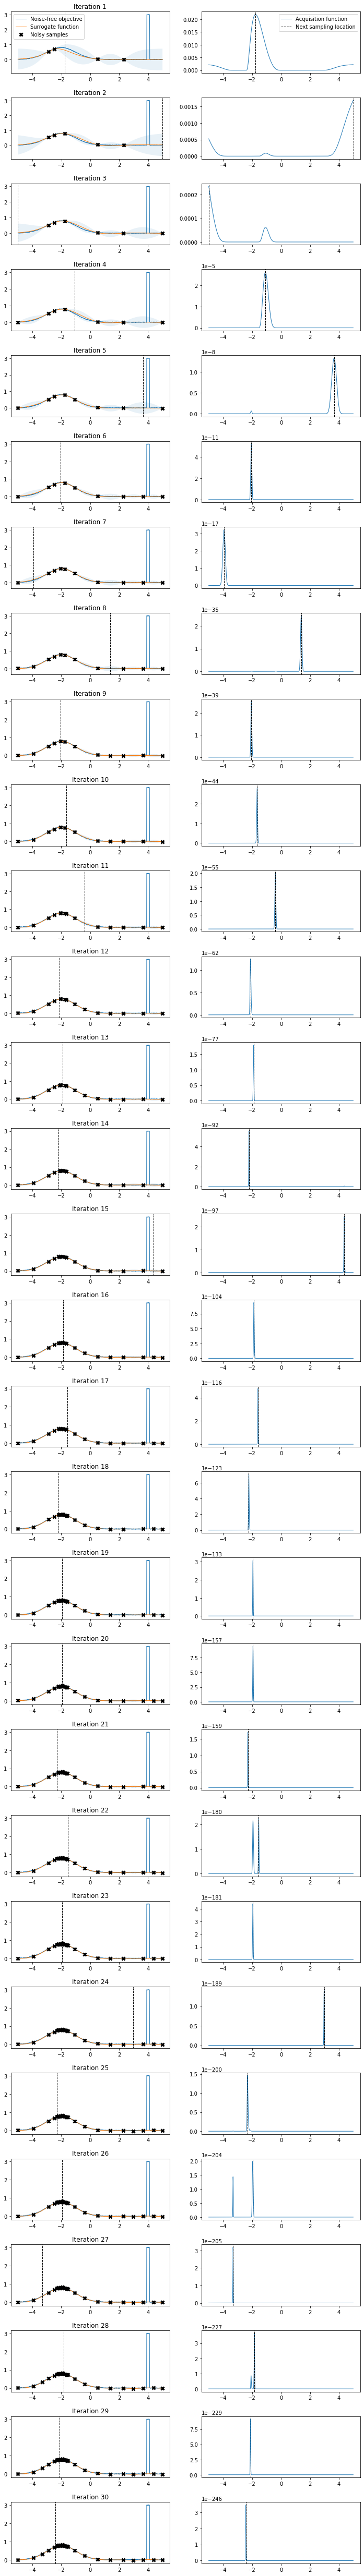

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
#from bayesian_optimization_util import plot_approximation, plot_acquisition

# Gaussian process with Mat??rn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 30

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next, acq_val = propose_location_with_acq_val(expected_improvement, X_sample, Y_sample, gpr, bounds)
    print(acq_val)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

Iteration 1 sampled from 1 [[-1.17111711]]
Iteration 2 sampled from 2 [[0.0970097]]
Iteration 3 sampled from 1 [[-1.93771291]]
Iteration 4 sampled from 2 [[5.]]
Iteration 5 sampled from 1 [[-5.]]
Iteration 6 sampled from 2 [[0.1540154]]
Iteration 7 sampled from 1 [[0.]]
Iteration 8 sampled from 2 [[3.61286129]]
Iteration 9 sampled from 1 [[-3.95889589]]
Iteration 10 sampled from 2 [[1.38613861]]
Iteration 11 sampled from 1 [[-1.70767077]]
Iteration 12 sampled from 2 [[4.28192819]]
Iteration 13 sampled from 1 [[-2.11171117]]
Iteration 14 sampled from 2 [[2.97129713]]
Iteration 15 sampled from 1 [[-2.12621262]]
Iteration 16 sampled from 2 [[1.84218422]]
Iteration 17 sampled from 1 [[-0.62806281]]
Iteration 18 sampled from 2 [[0.]]
Iteration 19 sampled from 1 [[-1.86418642]]
Iteration 20 sampled from 2 [[0.]]
Iteration 21 sampled from 1 [[-2.21172117]]
Iteration 22 sampled from 2 [[0.85558556]]
Iteration 23 sampled from 1 [[-1.60016002]]
Iteration 24 sampled from 2 [[0.]]
Iteration 25 sam

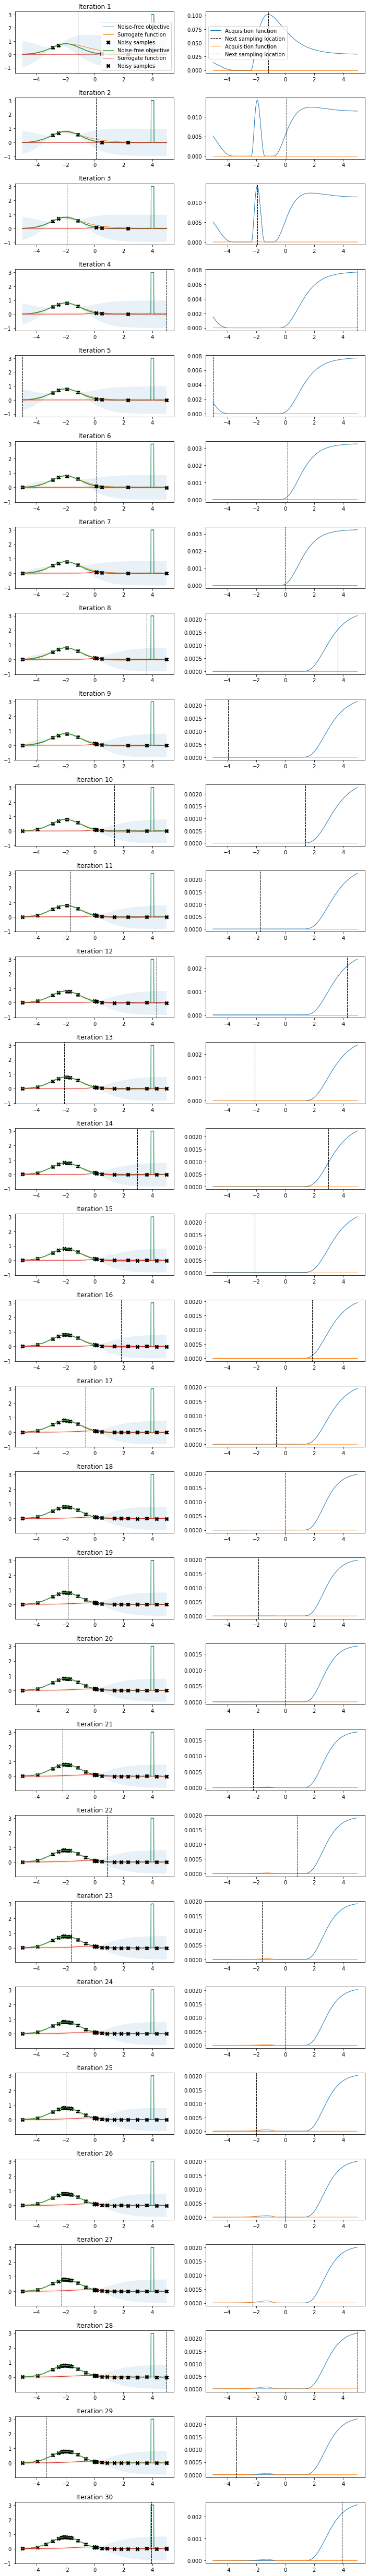

In [9]:
# Gaussian process with Mat??rn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

m52_2 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr_2 = GaussianProcessRegressor(kernel=m52_2, alpha=noise**2)

# Initialize samples
X_sample_1 = X_init[X_init <0].reshape(-1,1)
Y_sample_1 = f(X_sample_1)
bounds_1 = np.array([[-5.0, 0.0]])

X_sample_2 = X_init[X_init >= 0].reshape(-1,1)
Y_sample_2 = f(X_sample_2)
bounds_2 = np.array([[0.0, 5.0]])

# Number of iterations
n_iter = 30

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample_1, Y_sample_1)
    gpr_2.fit(X_sample_2, Y_sample_2)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next_1, acq_val_1 = propose_location_with_acq_val(expected_improvement, X_sample_1, Y_sample_1, gpr, bounds_1)
    
    X_next_2, acq_val_2 = propose_location_with_acq_val(expected_improvement, X_sample_2, Y_sample_2, gpr_2, bounds_2)
    
    
    
    
    X_next = X_next_1 if i%2 == 0 else X_next_2
    num = 1 if i%2==0 else 2
    Y_next = f(X_next)
    
    # Obtain next noisy sample from the objective function
    print("Iteration",(i+1),"sampled from",num,"%s"%str(X_next))
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample_1, Y_sample_1, X_next, show_legend=i==0)
    plot_approximation(gpr_2, X, Y, X_sample_2, Y_sample_2, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample_1, Y_sample_1, gpr), X_next, show_legend=i==0)
    plot_acquisition(X, expected_improvement(X, X_sample_2, Y_sample_2, gpr_2), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    #X_sample = np.vstack((X_sample, X_next))
    #Y_sample = np.vstack((Y_sample, Y_next))
    if(num == 1):
        X_sample_1 = np.vstack((X_sample_1, X_next))
        Y_sample_1 = np.vstack((Y_sample_1, Y_next))
    else:
        X_sample_2 = np.vstack((X_sample_2, X_next))
        Y_sample_2 = np.vstack((Y_sample_2, Y_next))